<a href="https://colab.research.google.com/github/samyakjain0112/Generative-models-papers-and-code/blob/master/normal_autoencoder_cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing all requirements
import torch as torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from sklearn.decomposition import PCA

In [0]:
#using the inbuilt Dataset class where all data is loaded into the cpu memory and using getitem we can get the data by just passing the corresponding index
train_data = dsets.CIFAR10(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.CIFAR10(root = './data', train = False,
                       transform = transforms.ToTensor())

Files already downloaded and verified


In [0]:
#loading all the data using Dataloaader inbuilt class it loads all the data again into the cpu memory without making a copy because it uses iter for it and even if suffle examples is true then also no cpy is 
#required it just reshuffles the order of the iteraror in the list. 
#NOTE: only when we will load the data for training in the training class then the data will be needed to be loaded in the gpu memory
batch_size=32
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [0]:
#Usually in the model class we need to inherit from nn.Module and use super class code otherwise the forward will not run.


class model(torch.nn.Module):
  def __init__(self,batch_size=32):
    super(model,self).__init__()
    self.batch_size=batch_size
    self.layer1=torch.nn.Conv2d(3,8,(3,3),stride=2,padding=1)
    self.layer2=torch.nn.Conv2d(8,16,(3,3),stride=2,padding=2)
    #self.layer3=torch.nn.Maxpool2d((3,3),2)
    self.layer4=torch.nn.Conv2d(16,32,(3,3),stride=2,padding=1)
    self.layer5=torch.nn.ConvTranspose2d(32,16,(3,3),stride=2,padding=1)
    self.layer6=torch.nn.ConvTranspose2d(16,8,(3,3),stride=2,padding=1)
    self.layer7=torch.nn.ConvTranspose2d(8,3,(3,3),stride=2,padding=1)

  def forward(self,x,latent_space=False,latent=None,marker=False,plot=False):
    x=self.layer1(x)

    x=self.layer2(x)
    #x=self.layer3(x)

    x=self.layer4(x)
    if plot==True:
      return x
    if latent_space==True:
      return x
    if marker==True:
      x=latent
    x=self.layer5(x)
    x=self.layer6(x)
    x=self.layer7(x)

    return x


In [0]:
#latent space visualization
class modify_space(object):
  def __init__(self,importer,test_gen,label=1,label2=2,num_latents=10):
    self.batch_size=1
    self.label=label
    self.label2=label2
    self.test_gen=test_gen
    self.num_latents=num_latents
    self.net=importer.net
    self.generate()
    self.latent()


  def generate(self):
    w=0
    e=0
    print("GENERATING LATENT IMAGE OUTPUTS")
    print(1)
    for (image,label) in self.test_gen:
      if w==1:
        break
      for i in range(len(label)):
        if (label[i].item())==self.label:
          self.image=image[i].expand(1,3,32,32).cuda()

          self.label=label[i].cuda()
          w=1
          break
    for (image,label) in self.test_gen:
      if e==1:
        break
      for i in range(len(label)):
        if (label[i].item())==self.label2:
          self.image2=image[i].expand(1,3,32,32).cuda()
          self.label2=label[i].cuda()
          e=1
          break

  def latent(self):
    latent1=self.net(self.image,latent_space=True)
    latent2=self.net(self.image2,latent_space=True)
    for count in range(self.num_latents+1):
      input_latent=(latent1*(count/(self.num_latents))+latent2*(1-count/self.num_latents))
      output=self.net(self.image2,latent=input_latent,marker=True)
      save_image(output,'latent_layer3prime_'+str(count)+'.png')

In [0]:
#visualizing the latent space points in two dimenions using principal component analysis
a=0
class plotter(object):
  def __init__(self,render):
    self.batch_size=1
    self.test_gen=test_gen
    self.net=render.net
    self.latent=[]
    self.label_array=[]
    self.visualize()
   
  def visualize(self):
    for (image,label) in self.test_gen:
      for i in range(len(label)):
        latent=self.net(image[i].expand(1,3,32,32).cuda(),plot=True).cpu().detach().numpy()
        latent_x=np.reshape(latent,(800))
        self.latent.append(latent_x)
        self.label_array.append(label[i].item())
        #feat_cols = ['feature'+str(i) for i in range(latent_x.shape[1])]
        #latent=pd.DataFrame(latent_x,columns=feat_cols)
        #print(latent.shape)
        #print(latent)

    pca_latent = PCA(n_components=2)
  
    twodim_pca = pca_latent.fit_transform(np.array(self.latent))
    colormap = np.array(['r', 'g', 'b','pink','orange','lightblue','black','brown','yellow','white'])
    for i in range(10):
      temp1=[]
      temp2=[]
      
      for j in range(len(self.label_array)):

        if self.label_array[j]==i:
          temp1.append(twodim_pca[j][0])
          temp2.append(twodim_pca[j][1]) 
      plt.scatter(temp1,temp2,c=colormap[i])
    plt.show()
    

In [0]:
#If we are building a class without using any functionality of any other class then object can be written it means that the class will return an object type dataset
#However if we write like data.Datasets of Sampler then it means that it will have functionality of the superclass data.Datasets or Sampler however ultimately these super classes will also return an object.
#so here in a way we are returning an object of the super class via the sub class.
#BUILDING A SIMPLE AUTOENCODER WHICH JUST AIMS AT RECONSTRUCTION WITHOUT ANY STOCHASTICITY

class training(object):

  def __init__(self,epochs=5,lr=0.001,train_g=train_gen,test_g=test_gen,generate_latent=False,plot=False):
    self.epochs=epochs
    self.lr=lr
    self.train_gen=train_g
    self.test_gen=test_g
    self.device='cuda'
    self.net=model().cuda()
    self.opt=torch.optim.Adam(self.net.parameters(),self.lr)
    self.loss=torch.nn.MSELoss()
    self.train()
    #self.test()
    if generate_latent==True:
      modify_space(self,test_gen)
    if plot==True:
      plotter(self)


  def train(self):
    for epoch_no in range(self.epochs):
      counter=0
      for (image,label) in self.train_gen:
        img=image.to(self.device)
        lab=label.to(self.device)
        self.opt.zero_grad()
        outputs = self.net(img)
        loss = self.loss(img,outputs[:,:,:32,:32])
        loss.backward()
        self.opt.step()
        counter+=1
        print("LOSS:",counter,loss.item())
      print("EPOCH OVER:",epoch_no)
   
  def test(self):
    count=0
    for (image,label) in self.train_gen:
      img=image.to(self.device)
      lab=label.to(self.device)
      outputs = self.net(img)
      count+=1
      print("Image_no",count)
      if count%1000==0:
        save_image(outputs,'smas'+str(count)+'.png')
       




Streaming output truncated to the last 5000 lines.
LOSS: 1260 0.0024572350084781647
LOSS: 1261 0.0028775676619261503
LOSS: 1262 0.0026297918520867825
LOSS: 1263 0.002728050108999014
LOSS: 1264 0.0022612554021179676
LOSS: 1265 0.0027194852009415627
LOSS: 1266 0.0023549648467451334
LOSS: 1267 0.0024763040710240602
LOSS: 1268 0.002402990125119686
LOSS: 1269 0.002337526995688677
LOSS: 1270 0.002508956240490079
LOSS: 1271 0.0023759938776493073
LOSS: 1272 0.002251677680760622
LOSS: 1273 0.002628076821565628
LOSS: 1274 0.0026417213957756758
LOSS: 1275 0.0020192041993141174
LOSS: 1276 0.0027434444054961205
LOSS: 1277 0.001961742527782917
LOSS: 1278 0.0026108212769031525
LOSS: 1279 0.002347828820347786
LOSS: 1280 0.0023558074608445168
LOSS: 1281 0.002694422844797373
LOSS: 1282 0.002326632384210825
LOSS: 1283 0.002445830963551998
LOSS: 1284 0.002506176009774208
LOSS: 1285 0.002432440407574177
LOSS: 1286 0.0025332027580589056
LOSS: 1287 0.0021477332338690758
LOSS: 1288 0.002340138889849186
LOSS: 

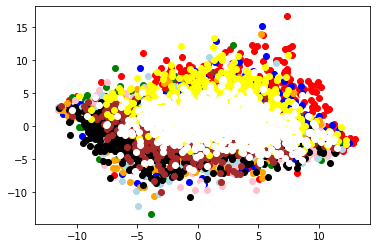

In [0]:
#here is all it begins and ends
obj=training(plot=True,generate_latent=True)


WE CAN SEE THE MIXING OCCURNG IN THE LATENT SPACE AND ESPECIALLY BECAUSE OF LOW DIMENSIONALITY 522 THOUGH THE POINTS IN LATENT SPACE ARE DISCRETE AND KIND OF ONE TO ONE MAPPING BUT THEY STILL SEEM TO BE QUITE CONTINUOUS. TAKING A HIGHER DIMENSIONAL DATASET MAY SHOW THE SPARSITY IN THE LATENT IN A BETTER WAY.

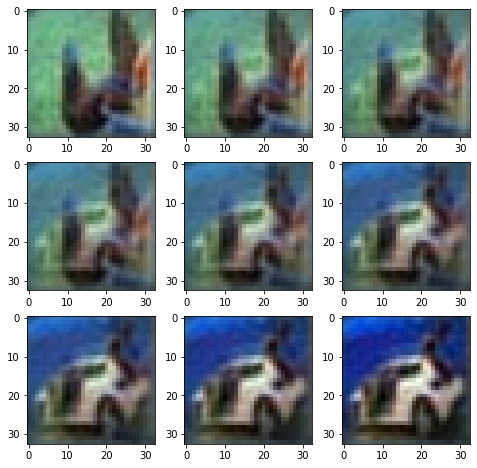

In [0]:
#layer3 visualization
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img=cv2.imread('latent_layer3prime_'+str(i)+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#layer2 visualization
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img=cv2.imread('latent_layer2_'+str(i)+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
#layer1 visualization
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img=cv2.imread('latent_layer1_'+str(i)+'.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

SO IT SEEMS THAT THE LATENT SPACE IS VERY CONTINUOUS BUT IN REALITY IT IS DISCRETE IN CASE OF A NORMAL AUTOENCODER TO VISUALIZE IT WE NEED A LARGER DIMENSION DATASET TO PROOVE IT WE NEED TO PLOT THE LATENT SPACE BY CONVERTING IT INTO TWO DIMENSIONS USING PCA

In [0]:
#here is all it begins and ends
obj=training(plot=True)


In [0]:
print(a)